In [1]:
import myutils
import pdkit_features
import synapseclient as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from IPython.display import display_html
sns.set_style("dark")
warnings.simplefilter("ignore")

%matplotlib inline
np.random.seed(100)

In [38]:
def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)

#### helper function ####
def measureSamplingFrequency(data):
    sample_frequency = data.shape[0]/data.td[-1]
    return sample_frequency

# def measureSamplingTime(data):
    
#     return data["td"][-1]

def measureTimeDelta(data):
    data['delta'] = (data['td']-data['td'].shift()).fillna(0)
    return data

# def measureSamplingInterval(delta, params):
#     delta = delta[delta>0]
#     if params == "mean":
#         mean_ = delta.mean()
#         return mean_
#     elif params == "max":
#         max_ = delta.max()
#         return max_
#     elif params == "min":
#         min_ = delta.min()
#         return min_
#     elif params == "median":
#         median_ = delta.median()
#         return median_
#     elif params == "std":
#         std_ = delta.std()
#         return std_
#     else:
#         range_ = max_ - min_
#         return range_
    
def samplingInterval(delta):
    delta = delta[delta>0]
    mean_ = delta.mean()
    max_ = delta.max()
    min_ = delta.min()
    median_ = delta.median()
    std_ = delta.std()
    range_ = max_ - min_
    return mean_, max_, min_, median_, std_, range_
        
    
    

def generateReport(data, os):
    mean, maximum, minimum, median, stdev, rng = samplingInterval(data["delta"])
    sampling_frequency = measureSamplingFrequency(data)
    data = pd.DataFrame({"mean sampling interval": [mean],
                         "maximum sampling interval": [maximum],
                         "minimum sampling interval": [minimum],
                         "median sampling interval": [median],
                         "std sampling interval": [stdev],
                         "range sampling interval": [rng],
                         "sampling frequency": [sampling_frequency]    
    }).T.rename(columns = {0: os})
    return data

def pipeline(filepath, sensor, calculation):
    data = myutils.gait_time_series(filepath)
    if data["td"][-1] > 25:
        if sensor == "accelerometer":
            data = data[data["sensorType"].str.contains("accel")]
            if data.shape[0] == 0:
                return np.NaN
        elif sensor == "gyro":
            if "gyro" not in data["sensorType"].unique():
                data = data[(data["sensorType"].str.contains("rotationRate"))]
            else:
                data = data[(data["sensorType"].str.contains("gyro"))]
            if data.shape[0] == 0:
                return np.NaN
        if calculation == "sampling_frequency":
            return measureSamplingFrequency(data)
        elif calculation == "sampling_interval":
            data = measureTimeDelta(data)
            return measureSamplingInterval(data)
    else:
        return "LACK SAMPLING TIME"

In [3]:
syn = sc.login()

Welcome, aryton tediarjo!



INFO:synapseclient_default:Welcome, aryton tediarjo!



## Retrieve Sample Data

In [4]:
ios_users = "select distinct healthCode FROM syn12514611 where phoneInfo like 'iPhone%'"
ios_users = syn.tableQuery(ios_users).asDataFrame()
android_users = "select distinct healthCode FROM syn12514611 where phoneInfo not like 'iPhone%'"
android_users = syn.tableQuery(android_users).asDataFrame()
ios_users = list(ios_users.sample(10)["healthCode"])
android_users = list(android_users.sample(10)["healthCode"])
users = ios_users + android_users
my_data = ["1bce95ce-95d8-4bb5-8df4-bcf46418d312", "6d9b0436-6740-4c50-81ea-4696647b49fb" ]
code_list = users + my_data

In [5]:
data = myutils.get_synapse_table(syn, code_list, "syn12514611")

INFO:synapseclient_default:Downloading 0 files, 644 cached locally


## Analysis on Self Walking Data

In [9]:
## Retrieve most recent recordIds
ios_data = data[data["recordId"] == "796074c5-cb7c-43c1-b07d-1fe4ed4ac1ba"]
android_data = data[data["recordId"] == "e85bdfbc-2727-4fea-a6f0-cad07d2b3f9f"]

## ios data
ios_walking_ts = myutils.gait_time_series(ios_data["walk_motion.json_pathfile"].iloc[0])
ios_balance_ts = myutils.gait_time_series(ios_data["balance_motion.json_pathfile"].iloc[0])

## android data
android_walking_ts = myutils.gait_time_series(android_data["walk_motion.json_pathfile"].iloc[0])
android_balance_ts = myutils.gait_time_series(android_data["balance_motion.json_pathfile"].iloc[0])

### a. Summary Statistics

In [10]:
ios_walking_ts.drop(["td"], axis = 1).groupby("sensorType").agg(["mean", "median", "count"])

x                         y                  \
                      mean    median count      mean    median count   
sensorType                                                             
accelerometer     0.452652  0.454269  3081  0.913559  0.868896  3081   
attitude         -0.632528 -0.623370  2984  0.362758  0.359437  2984   
gravity           0.523138  0.528896  2984  0.811904  0.842848  2984   
gyro              0.002325  0.127014  2983 -0.042541 -0.139029  2983   
rotationRate      0.029125  0.154077  2984 -0.053940 -0.150682  2984   
userAcceleration -0.069668 -0.039659  2984  0.103833  0.028773  2984   

                         z                        AA                  
                      mean    median count      mean    median count  
sensorType                                                            
accelerometer     0.025618 -0.019272  3081  1.097054  1.019096  3081  
attitude          0.037625  0.034298  2984  0.736453  0.733068  2984  
gravity           0.082576  0.068202  2984  1.000000  1.000000  2984  
gyro              0.077612 -0.014219  2983  1.427234  1.183517  2983  
rotationRate      0.075215 -0.016831  2984  1.431812  1.193293  2984  
userAcceleration -0.055880 -0.009321  2984  0.431988  0.358866  2984

In [11]:
android_walking_ts.drop(["td"], axis = 1).groupby("sensorType").agg(["mean", "median", "count"])

x                         y                         z  \
                  mean    median count      mean    median count      mean   
sensorType                                                                   
acceleration  0.222481  0.217269   149 -0.986226 -0.994754   149 -0.040244   
rotationRate -0.212505 -0.113129   148  0.859622  0.919678   148  0.136604   

                                    AA                  
                median count      mean    median count  
sensorType                                              
acceleration -0.018696   149  1.019680  1.018814   149  
rotationRate  0.053261   148  1.177307  1.172444   148

The summary statistics above shows that the count aggregation for ios and android is far different. This is an indication that the sampling frequency of android is far lower than those using iOS. 

In [12]:
accel_ios_data = measureTimeDelta(ios_walking_ts[ios_walking_ts["sensorType"] == "accelerometer"])
gyro_ios_data = measureTimeDelta(ios_walking_ts[ios_walking_ts["sensorType"] == "gyro"])
accel_android_data = measureTimeDelta(android_walking_ts[android_walking_ts["sensorType"] == "acceleration"])
gyro_android_data = measureTimeDelta(android_walking_ts[android_walking_ts["sensorType"] == "rotationRate"])

#### b. Report on my Sampled mPower Data ###

Table on the left is the iOS data, whereas table on the right is the mpower data from the Android 

In [18]:
## acceleration data
display_side_by_side(generateReport(accel_ios_data, "iPhone6"), generateReport(accel_android_data, "LG"))

,iPhone6
mean sampling interval,0.009868
maximum sampling interval,0.019490
minimum sampling interval,0.009669
median sampling interval,0.009734
std sampling interval,0.001133
range sampling interval,0.009821
sampling frequency,102.762766
,LG
mean sampling interval,0.201007
maximum sampling interval,0.201416


In [19]:
## gyro data
display_side_by_side(generateReport(gyro_ios_data, "iPhone6"), generateReport(gyro_android_data, "LG"))

,iPhone6
mean sampling interval,0.010253
maximum sampling interval,0.030021
minimum sampling interval,0.009972
median sampling interval,0.010000
std sampling interval,0.001608
range sampling interval,0.020049
sampling frequency,99.530959
,LG
mean sampling interval,0.201011
maximum sampling interval,0.201324


From this table, we can see that the iOS mPower data has a far larger sampling frequency when compared to LG Android OS (102.8 to 5). This difference in value can cause the Android data to be less granular, which can cause a bias in the features retrieved from the Android.

# Is this the case for all Android and iOS mPower2.0 Data?

In [20]:
map_ios = lambda x: "iOS" if "iPhone" in x else "Android"

data["OS"] = data["phoneInfo"].apply(map_ios)

In [39]:
def featurize(data):
    data["accel_sampling_frequency"] = data["walk_motion.json_pathfile"].apply(pipeline, sensor = "accelerometer", calculation = "sampling_frequency")
#     data["sampling_interval"] = data["walk_motion.json_pathfile"].apply(pipeline, sensor = "accelerometer", calculation = "sampling_interval")
    data["gyro_sampling_frequency"] = data["walk_motion.json_pathfile"].apply(pipeline, sensor = "gyro", calculation = "sampling_frequency")
#     data["sampling_interval"] = data["walk_motion.json_pathfile"].apply(pipeline, sensor = "gyro", calculation = "sampling_interval")
#     data["samplingTime"] = datadata["walk_motion.json_pathfile"].apply(pipeline, sensor = "gyro", calculation = "sampling_frequency")
    return data

In [40]:
data = featurize(data)

In [42]:
sub_data = data[(data["accel_sampling_frequency"] != "LACK SAMPLING TIME") & (data["gyro_sampling_frequency"] != "LACK SAMPLING TIME")]
sub_data["accel_sampling_frequency"] = sub_data["accel_sampling_frequency"].apply(lambda x: float(x))
sub_data["gyro_sampling_frequency"] = sub_data["gyro_sampling_frequency"].apply(lambda x: float(x))

In [43]:
sub_data[["accel_sampling_frequency","gyro_sampling_frequency","phoneInfo", "OS"]].groupby("OS").agg(["count", "mean", "median"])

accel_sampling_frequency                        \
                           count       mean     median   
OS                                                       
Android                      130  29.541129  37.784204   
iOS                          189  99.933432  99.807558   

        gyro_sampling_frequency                        
                          count       mean     median  
OS                                                     
Android                      92   9.579449   6.344816  
iOS                         189  99.316086  99.712284

In [45]:
sub_data["phoneInfo"] = sub_data["phoneInfo"].apply(lambda x: "iPhone" if "iPhone" in x else x)

In [46]:
sub_data[["accel_sampling_frequency","gyro_sampling_frequency","phoneInfo", "OS"]].groupby("phoneInfo").agg(["count", "mean", "median"])

accel_sampling_frequency             \
                                                       count       mean   
phoneInfo                                                                 
Google Android SDK built for x86_64                        1   4.952085   
Google Pixel                                               2   6.310268   
Google Pixel XL                                           45  50.768997   
LGE LM-Q710.FG                                             4  27.413004   
Motorola XT1034                                           38   6.365089   
Samsung SM-G900T                                          23  20.648525   
Samsung SM-G930V                                          17  41.866343   
iPhone                                                   189  99.933432   

                                               gyro_sampling_frequency  \
                                        median                   count   
phoneInfo                                                                
Google Android SDK built for x86_64   4.952085                       1   
Google Pixel                          6.310268                       2   
Google Pixel XL                      50.766488                      45   
LGE LM-Q710.FG                       27.405239                       4   
Motorola XT1034                       5.033558                       0   
Samsung SM-G900T                      5.720208                      23   
Samsung SM-G930V                     53.075898                      17   
iPhone                               99.807558                     189   

                                                           
                                          mean     median  
phoneInfo                                                  
Google Android SDK built for x86_64   5.018556   5.018556  
Google Pixel                          6.201774   6.201774  
Google Pixel XL                      10.586890   6.358248  
LGE LM-Q710.FG                        4.986647   4.981657  
Motorola XT1034                            NaN        NaN  
Samsung SM-G900T                      9.948866   5.602486  
Samsung SM-G930V                      8.159211   5.362482  
iPhone                               99.316086  99.712284

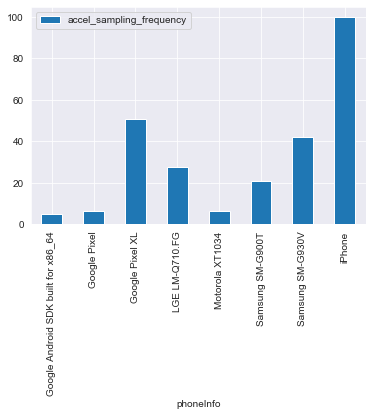

In [47]:
sub_data[["accel_sampling_frequency","phoneInfo", "OS"]].groupby("phoneInfo").mean().plot(kind = "bar")
plt.grid()

Data from android will not be implemented to any feature calculation as it has severely inconsistent sampling rate, which in turn, can cause a bias towards signal processing calculation like fourier transform.